In [1]:
from __future__ import annotations

import numpy as np
import pandas as pd
import seaborn as sns

from typing import *


sns.set(style="darkgrid")

In [2]:
from nepal.datasets import NYTimes, PopulationDensity
from nepal.ml.preprocess import Cases, Population
from nepal.ml.transformers import log_transformer

df: pd.DataFrame = Cases(NYTimes()).preprocessed()
extra_pop: pd.DataFrame = Population(PopulationDensity()).preprocessed()

df_y: pd.DataFrame = log_transformer.transform(df[["new_cases"]])
df_y

new_cases
fips  date                 
01001 2020-01-21   0.000000
      2020-01-22   0.000000
      2020-01-23   0.000000
      2020-01-24   0.000000
      2020-01-25   0.000000
...                     ...
78030 2022-04-07   2.371578
      2022-04-08   2.448539
      2022-04-09   2.448539
      2022-04-10   2.448539
      2022-04-11   2.448539

[2614640 rows x 1 columns]

In [5]:
# Hyperparameters found

best_lag: int = 17

Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

0.37715012926854374


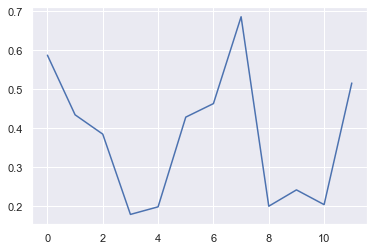

In [3]:
import lightgbm as lgb
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import SlidingWindowSplitter

from nepal.ml.loss import mape
from nepal.ml.forecaster import LGBMForecaster
from nepal.ml.splitter import Splitter
from nepal.ml.validate import cross_validate

fh = ForecastingHorizon(list(range(1, 15)))
cv = SlidingWindowSplitter(fh=fh, window_length=120, step_length=60)
splitter: Splitter = Splitter(cv)

# Create regressor with default parameters
forecaster = LGBMForecaster(lgb.LGBMRegressor(objective=mape.name), lag=best_lag)

scores: Sequence[float] = cross_validate(
    forecaster, splitter=splitter, y=df_y, loss=mape.function
)

sns.lineplot(data=scores)
print(np.mean(scores))

Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

0.3748754722150907


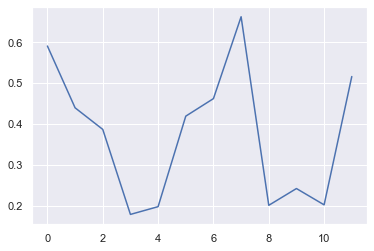

In [4]:
# Create regressor with default parameters
forecaster = LGBMForecaster(lgb.LGBMRegressor(objective=mape.name), lag=best_lag)

scores: Sequence[float] = cross_validate(
    forecaster, splitter=splitter, y=df_y, Xs=[extra_pop], loss=mape.function
)

sns.lineplot(data=scores)
print(np.mean(scores))

Cross Validation:   0%|          | 0/12 [00:00<?, ?it/s]

0.3725283654949331


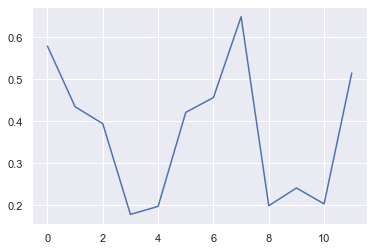

In [7]:
from sklearn.pipeline import Pipeline
from nepal.ml.transformers import RollingWindowSum, log_transformer

transformers: Pipeline = Pipeline(
    [
        (
            "with_active_infections",
            RollingWindowSum(
                "new_cases", target="infections", window=10, transformer=log_transformer
            ),
        ),
    ]
)

forecaster = LGBMForecaster(
    lgb.LGBMRegressor(objective=mape.name), lag=best_lag, transformers=transformers
)

scores: Sequence[float] = cross_validate(
    forecaster, splitter=splitter, y=df_y, Xs=[extra_pop], loss=mape.function
)

sns.lineplot(data=scores)
print(np.mean(scores))

In [8]:
import optuna


def objective(trial: optuna.Trial) -> float:
    lag = trial.suggest_int("lag", 10, 24)
    forecaster = LGBMForecaster(
        lgb.LGBMRegressor(objective=mape.name), lag=lag, transformers=transformers
    )

    scores: Sequence[float] = cross_validate(
        forecaster, splitter=splitter, y=df_y, Xs=[extra_pop], loss=mape.function
    )
    return np.mean(scores)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

study.best_params
# Best found lag value with default LGBM params: 17

[I 2022-06-03 10:27:08,574] A new study created in memory with name: no-name-f5f0f9c0-8361-41f9-a0d6-de4414a1e271


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-03 10:38:29,718] Trial 0 finished with value: 0.37453985641905546 and parameters: {'lag': 23}. Best is trial 0 with value: 0.37453985641905546.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-03 10:47:47,075] Trial 1 finished with value: 0.3725283654949331 and parameters: {'lag': 17}. Best is trial 1 with value: 0.3725283654949331.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-03 10:58:23,295] Trial 2 finished with value: 0.37330029514569646 and parameters: {'lag': 24}. Best is trial 1 with value: 0.3725283654949331.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-03 11:07:27,904] Trial 3 finished with value: 0.37518475029141807 and parameters: {'lag': 11}. Best is trial 1 with value: 0.3725283654949331.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-03 11:16:55,861] Trial 4 finished with value: 0.375661437334359 and parameters: {'lag': 10}. Best is trial 1 with value: 0.3725283654949331.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-03 11:26:25,504] Trial 5 finished with value: 0.37462178901813825 and parameters: {'lag': 13}. Best is trial 1 with value: 0.3725283654949331.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-03 11:36:01,433] Trial 6 finished with value: 0.37462178901813825 and parameters: {'lag': 13}. Best is trial 1 with value: 0.3725283654949331.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-03 11:47:24,832] Trial 7 finished with value: 0.3732829518050142 and parameters: {'lag': 22}. Best is trial 1 with value: 0.3725283654949331.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-03 11:59:17,259] Trial 8 finished with value: 0.37330029514569646 and parameters: {'lag': 24}. Best is trial 1 with value: 0.3725283654949331.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-03 12:09:41,140] Trial 9 finished with value: 0.3735501707737354 and parameters: {'lag': 18}. Best is trial 1 with value: 0.3725283654949331.


{'lag': 17}

In [16]:
from nepal.graph import Connection, LocalConnection

conn: Connection = LocalConnection(
    database="neo4j",
    password="corona",
)

assert conn.is_up()

In [ ]:
import optuna
import lightgbm as lgb
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import SlidingWindowSplitter

from nepal.ml.forecaster import LGBMForecaster
from nepal.ml.splitter import Splitter

from nepal.graph.gds import CountyEmbedding


embedding = CountyEmbedding()
embedding.create_projection(conn)

fh = ForecastingHorizon(list(range(1, 15)))
cv = SlidingWindowSplitter(fh=fh, window_length=120, step_length=60)
splitter: Splitter = Splitter(cv)


def objective(trial: optuna.Trial) -> float:
    forecaster = LGBMForecaster(
        lgb.LGBMRegressor(objective=mape.name), lag=18, transformers=transformers
    )

    neo4j: pd.DataFrame = embedding.load_dataframe(
        connection=conn,
        embedding_dimension=trial.suggest_int("dim", 128, 512, log=True),
        weight2=trial.suggest_float("weight2", 0.0, 1.0),
        weight3=trial.suggest_float("weight3", 0.0, 1.0),
        weight4=trial.suggest_float("weight4", 0.0, 1.0),
        normalization=trial.suggest_float("normalization", -1.0, 1.0),
        property_ratio=trial.suggest_float("prop_ratio", 0.0, 1.0),
        self_influence=trial.suggest_float("self_influence", 0.0, 1.0),
    )

    scores: Sequence[float] = cross_validate(
        forecaster,
        splitter=splitter,
        y=df[["new_cases"]],
        Xs=[extra_pop, neo4j],
        loss=mape.function,
    )
    return np.mean(scores)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25)

study.best_params
# Best found values with default LGBM params and lag=12:
# {'dim': 13,
#  'weight2': 0.9095431576049532,
#  'weight3': 0.3804723961743889,
#  'weight4': 0.9975167117131349,
#  'normalization': -0.9871365897384008,
#  'prop_ratio': 0.12685783148389826,
#  'self_influence': 0.44962816623765073}

/Users/personal/Documents/Master of Statistics/2/Modern Data Analytics/Project/G0Z39a/src/nepal/graph/gds/embedding.py:73: UserWarning: {code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke procedure `gds.graph.project`: Caused by: java.lang.IllegalArgumentException: A graph with name 'counties' already exists.}
  warnings.warn(str(e))
[I 2022-06-02 21:25:04,381] A new study created in memory with name: no-name-57e03020-97ec-4bf4-acce-d3d410597f1f


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-02 21:35:33,874] Trial 0 finished with value: 1.214076252986109 and parameters: {'dim': 408, 'weight2': 0.39278214194521766, 'weight3': 0.8137099329508811, 'weight4': 0.3071328418127124, 'normalization': 0.2372850761336367, 'prop_ratio': 0.26756988069025145, 'self_influence': 0.678000929249061}. Best is trial 0 with value: 1.214076252986109.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-02 21:43:19,912] Trial 1 finished with value: 1.2125646198488904 and parameters: {'dim': 210, 'weight2': 0.4220780500930186, 'weight3': 0.32985761428142546, 'weight4': 0.5968719136353636, 'normalization': 0.45863988740932604, 'prop_ratio': 0.1431323571731158, 'self_influence': 0.10243912001333766}. Best is trial 1 with value: 1.2125646198488904.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

In [13]:
# Evaluate found parameters

fh = ForecastingHorizon(list(range(1, 15)))
cv = SlidingWindowSplitter(fh=fh, window_length=120, step_length=60)
splitter: Splitter = Splitter(cv)

# Create regressor with default parameters
forecaster = LGBMForecaster(lgb.LGBMRegressor(), lag=12)
embedding = CountyEmbedding()

X: pd.DataFrame = embedding.load_dataframe(
    connection=conn,
    embedding_dimension=16,
    weight2=0.9,
    weight3=0.4,
    weight4=1.0,
    normalization=-1.0,
    property_ratio=0.15,
    self_influence=0.45,
)

scores: Sequence[float] = cross_validate(
    forecaster, splitter=splitter, y=df[["new_cases"]], Xs=[X]
)

print(np.mean(scores))

Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

1.1615128487786013
